# Демо блокнот №02_02. ResNet своими руками

## Импорт зависимостей

In [1]:
%pip install clearml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import requests
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as F

import gc
from functools import partial
from tqdm import tqdm
from matplotlib import pyplot as plt

from clearml import Task, Logger

from pathlib import Path
from typing import Dict, Tuple, List, Optional, Callable

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, recall_score, precision_score, f1_score

import os
import io
import tarfile
import hashlib
from typing import Callable, Optional, Tuple, List

from concurrent.futures import ThreadPoolExecutor, as_completed


## Проверка доступности GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Доступное устройство для обучения: {device}')

Доступное устройство для обучения: cuda


## Функции для фиксации seed

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def make_cuda_deterministic() -> None:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def provide_reproducibility(seed: int = 42) -> None:
    set_seed(seed)
    make_cuda_deterministic()

## Класс-обертка над датасетом

Мы будем решать задачу классификации изображений из датасета Food101. Нам не придется сейчас загружать этот датасет, так какон уже загружен и существует в виде сущности `Dataset`

In [5]:
FOOD101_DATASET_PATH = '/home/jupyter/datasphere/datasets/food101/food-101'

In [6]:


class Food101Dataset(Dataset):
    """
    Custom PyTorch Dataset for Food-101.
    """
    def __init__(
        self,
        ds_path: str,
        split: str = "train", # 'train' | 'test',
        resize: Tuple[int, int] = (32, 32),
        dtype: torch.dtype = torch.uint8,   # хранение в RAM: torch.uint8 (экономия памяти) или torch.float32
        fraction: float = 1.0,  # сколько % от данных мы будем использовать
        num_workers_io: int = 0,
        normalize_on_getitem: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        verify_integrity: bool = False,
        seed: int = 42,
    ):
        assert split in {"train", "test"}
        self.ds_path = Path(ds_path)
        self.transform = transform
        self.target_transform = target_transform
        self.split = split
        self.resize = resize
        self.dtype = dtype
        self.num_workers_io = num_workers_io
        self.normalize_on_getitem = normalize_on_getitem

        # Проверяем доступность поддиректорий
        meta_dir = Path(self.ds_path) / 'meta'
        img_dir = Path(self.ds_path) / 'images'
    
        if not meta_dir.is_dir() or not img_dir.is_dir():
            raise RuntimeError(
                f"Food-101 not found under {self.ds_path}. "
                f"Use download=True or place extracted 'food-101' folder there."
            )

        # Загружаем список меток (лейблов, классов)
        classes_path = meta_dir / "classes.txt"
        
        with open(classes_path, "r", encoding="utf-8") as f:
            self.classes: List[str] = [line.strip() for line in f if line.strip()]
        self.class_to_idx = {cls: index for index, cls in enumerate(self.classes)}

        # Загружаем номера изображений для каждого подмножества
        split_path = meta_dir / f"{split}.txt"
        with open(split_path, "r", encoding="utf-8") as f:
            rel_ids = [line.strip() for line in f if line.strip()]  # e.g. 'apple_pie/1005649'
            
        # применим fraction
        if fraction < 100.0:
            torch.manual_seed(seed)
            idx = torch.randperm(len(rel_ids))[: int(len(rel_ids) * (fraction / 100.0))]
            rel_ids = [rel_ids[i] for i in idx.tolist()]
            
        # Создаем список адресов до картинок
        self.samples: List[Tuple[str, int]] = []
        for rid in rel_ids:
            cls, stem = rid.split("/", 1)
            img_path = img_dir / cls / f'{stem}.jpg'
            if not img_path.is_file():
                # некоторые форки могут содержать png; подстрахуемся
                alt = img_path[:-4] + ".png"
                if alt.is_file():
                    img_path = alt
                else:
                    # пропустим битые записи, но можно и выкидывать исключение
                    continue
            self.samples.append((img_path, self.class_to_idx[cls]))
            
        # ---- ПРЕДЗАГРУЗКА В RAM ----
        H, W = resize
        C = 3
        N = len(self.samples)

        # Выбираем форму хранения (uint8 или float32)
        if self.dtype == torch.uint8:
            self.images = torch.empty((N, C, H, W), dtype=torch.uint8)
        elif self.dtype == torch.float32:
            self.images = torch.empty((N, C, H, W), dtype=torch.float32)
        else:
            raise ValueError("dtype должен быть torch.uint8 или torch.float32")

        self.labels = torch.empty((N,), dtype=torch.long)

        def _load_one(i, path, y):
            with Image.open(path) as im:
                im = im.convert("RGB").resize((W, H), Image.BILINEAR)
                t = F.pil_to_tensor(im)  # uint8, CxHxW
                if self.dtype == torch.float32:
                    t = t.float().div_(255.0)
                    
            self.images[i].copy_(t if t.dtype == self.images.dtype else t.to(self.images.dtype))
            self.labels[i] = y

        
        # --- ОДИН ПОТОК + прогресс-бар ---
        if self.num_workers_io == 0:
            for i, (p, y) in enumerate(tqdm(self.samples, desc="Preloading images (single thread)")):
                _load_one(i, p, y)
        else:
            from concurrent.futures import ThreadPoolExecutor, as_completed
            with ThreadPoolExecutor(max_workers=num_workers_io) as ex:
                futures = [ex.submit(_load_one, i, p, y) for i, (p, y) in enumerate(self.samples)]
                for _ in tqdm(as_completed(futures), total=len(futures), desc="Preloading images"):
                    pass
            

        if verify_integrity:
            # Лёгкая проверка: посчитать sha1 имён + количество
            h = hashlib.sha1()
            for p, y in self.samples[:1000]:  # чтобы не тормозить — на подмножестве
                h.update((p + str(y)).encode())
            self._integrity_digest = h.hexdigest()

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int):
        img = self.images[index]
        target = int(self.labels[index])

        # Если хранение uint8 — конвертируем в float32/255 по запросу
        if self.normalize_on_getitem and img.dtype == torch.uint8:
            img = img.float().div(255.0)

        # Доп. трансформации (ожидают тензор CxHxW)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


Сделаем тестовую загрузку, чтобы убедиться, что все ок

In [7]:
food_train_dataset = Food101Dataset(
    ds_path=FOOD101_DATASET_PATH,
    split='train',
    resize=(64, 64)
)

Preloading images (single thread): 100%|██████████| 757/757 [00:05<00:00, 149.97it/s]


In [8]:
food_train_dataset[10][0].dtype

torch.float32

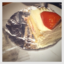

In [9]:
torchvision.transforms.ToPILImage()(food_train_dataset[10][0])

## Собираем ResNet

### Сверточный блок

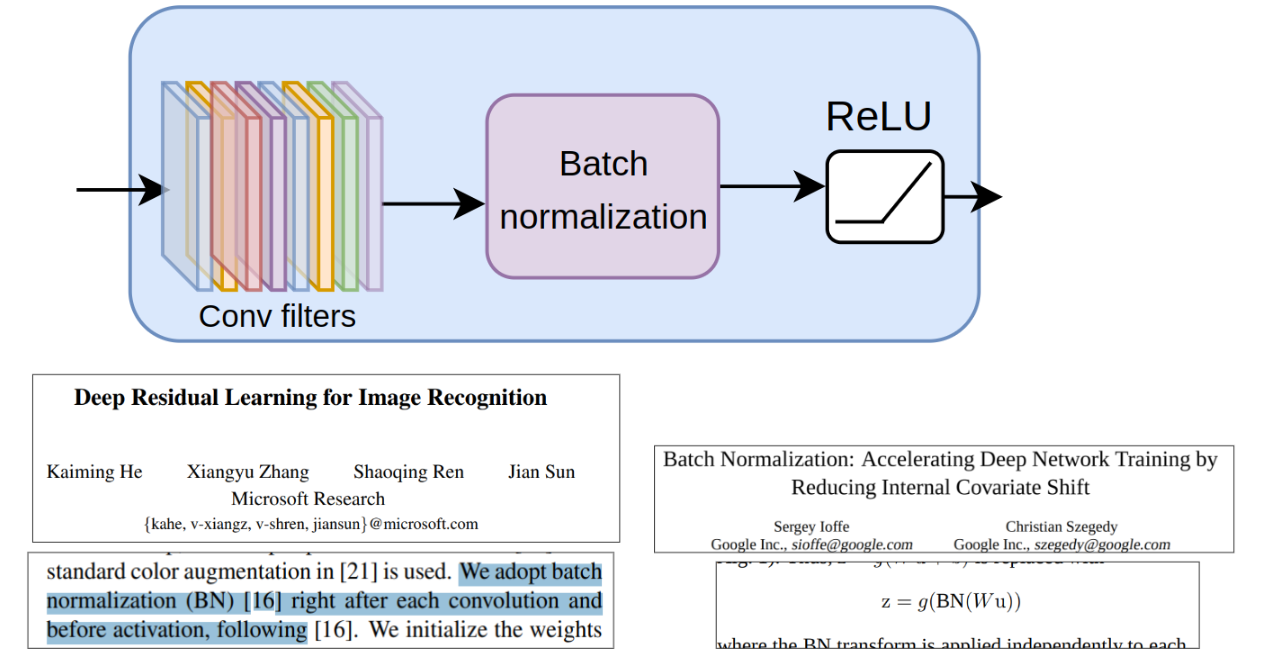

In [10]:
class ConvBlock(nn.Module):
    def __init__(
            self,
            input_channels: int,
            output_channels: int,
            kernel_size: int = 3,
            padding: int = 1,
            activation: bool = True,
        ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                input_channels,
                output_channels,
                stride=1,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(output_channels),
            nn.ReLU() if activation else nn.Identity()
        )

    def forward(self, x):
        return self.layers(x)

example_of_block = ConvBlock(3, 18)
example_of_block(torch.rand(64, 3, 244, 244)).shape

torch.Size([64, 18, 244, 244])

### Residaul Module

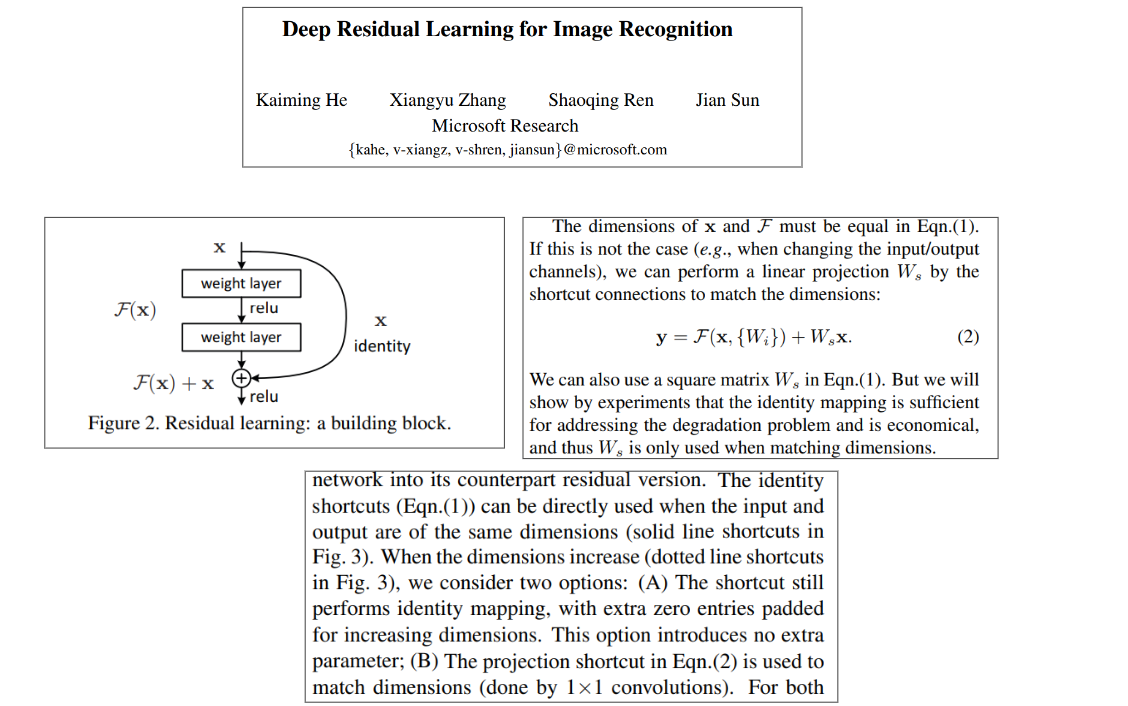

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.mismatch = not input_channels == output_channels

        self.residual_conv = ConvBlock(
            input_channels,
            output_channels,
            kernel_size=1,
            padding=0,
            activation=False
        )

        self.convolutions = nn.Sequential(
            ConvBlock(input_channels, output_channels),
            ConvBlock(output_channels, output_channels, activation=False),
        )

        self.activation = nn.ReLU()

    def residual_connection(self, x):
        if self.mismatch:
            return self.convolutions(x) + self.residual_conv(x)
        else:
            return self.convolutions(x) + x

    def forward(self, x):
        return self.activation(self.residual_connection(x))

ResidualBlock(3,32)(torch.randn((64, 3, 244, 244))).shape, ResidualBlock(32,32)(torch.randn((64,32,244,244))).shape

(torch.Size([64, 32, 244, 244]), torch.Size([64, 32, 244, 244]))

### Max Pooling

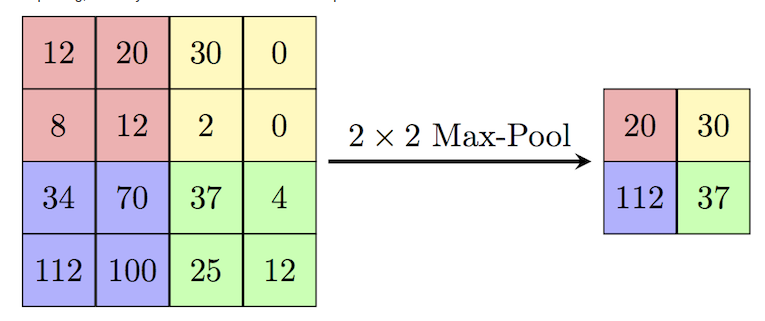

In [12]:
nn.MaxPool2d(4)(torch.randn((64,3,144,144))).shape, nn.MaxPool2d(2)(torch.randn((64,3,7,7))).shape

(torch.Size([64, 3, 36, 36]), torch.Size([64, 3, 3, 3]))

### Global Average Pooling

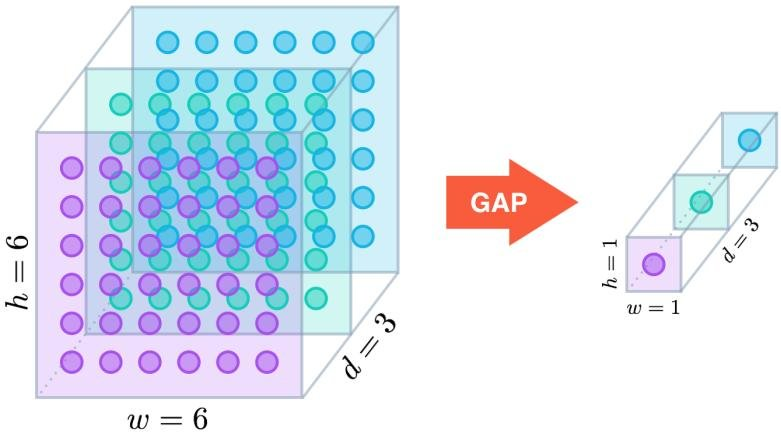

In [13]:
nn.AdaptiveAvgPool2d((1,1))(torch.randn((64,128,7,7))).shape, nn.AdaptiveAvgPool2d((1,1))(torch.randn((64,256,2,2))).shape

(torch.Size([64, 128, 1, 1]), torch.Size([64, 256, 1, 1]))

### Развертвывание

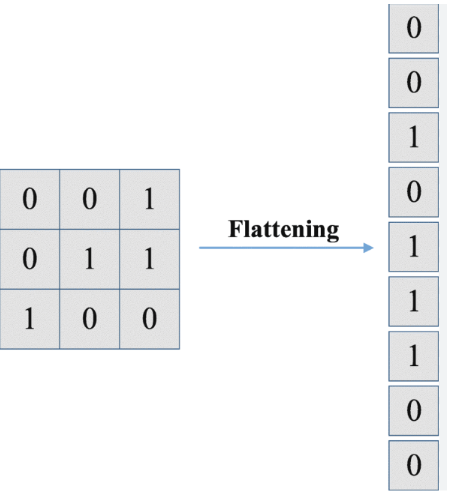

### Финальное отображение в таргет

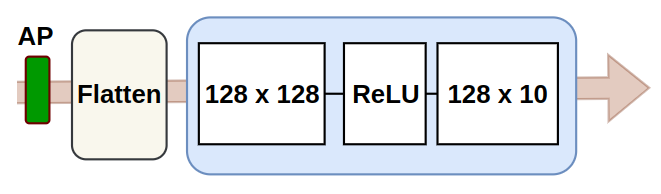

### Собираем все вместе

In [14]:
def get_backbone_layers(channels: list, maxpool_kernel: int = 2):
    layers = list()

    layers.extend([ConvBlock(3, channels[0]), nn.MaxPool2d(maxpool_kernel)])
    for in_channels, out_channels  in zip(channels[:-1], channels[1:]):
        layers.extend([
            ResidualBlock(in_channels, out_channels),
            nn.MaxPool2d(maxpool_kernel),
        ])

    layers.append(nn.AdaptiveAvgPool2d((1, 1)))

    return nn.Sequential(*layers)

In [15]:
class ResNet(nn.Module):
    def __init__(self, channels: list, maxpool_kernel: int):
        super().__init__()
        self.backbone_net = get_backbone_layers(channels, maxpool_kernel)

        self.output_head = nn.Sequential(
            nn.Linear(channels[-1], channels[-1]),
            nn.ReLU(),
            nn.Linear(channels[-1], 101)
        )

    def forward(self, x):
        x = self.backbone_net(x)

        x = x.view(x.size(0), -1)

        x = self.output_head(x)

        return x

ResNet([10, 16], 2)(torch.rand(1, 3, 32, 32)).shape

torch.Size([1, 101])

In [16]:
ResNet([10, 16, 16, 32, 32, 64, 128, 64], 4)

ResNet(
  (backbone_net): Sequential(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (residual_conv): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
      (convolutions): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): Conv

## Обучение модели

### Параметры эксперимента

In [30]:
SEED = 42

BATCH_SIZE = 256
FRACTION = 25.0
NUM_WORKERS = 4
IMAGE_RESOLUTION = 128, 128

EPOCHS = 50
LR = 3e-4

LAYERS = [10, 16]
MAXPOOL_WIDTH = 2

[D 2025-09-23 17:45:20.203 MLKernelApp] _pre_run_cell()


### Логгирование с clear ml

In [18]:
from clearml import Task

Task.set_credentials(
    api_host="https://api.clear.ml",
    web_host="https://app.clear.ml",
    files_host="https://files.clear.ml",
    key="NU3EQI4G5U5S8JVY5J6VJUCAUIAE25",
    secret="WZ1w6UyIughwbnRkXtZnO8SVc_DdH-5keb3dv8_dbEKh4NlrWEozKL8ZS3nqkNYvo5U",
    store_conf_file=True, 
)

task = Task.init(
    project_name="FOOD101",
    task_name=f"ResNet-test-6"
)

Could not store credentials in configuration file, '/home/jupyter/clearml.conf' already exists


ClearML Task: created new task id=871a405eacac4a089c06662ed6765d6a
2025-09-23 17:41:07,640 - clearml.Task - INFO - No repository found, storing script code instead


2025-09-23 17:41:11.348790: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 17:41:16.435423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 17:41:19.829674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ClearML results page: https://app.clear.ml/projects/c3d68fbcf96841f68a80766260573d63/experiments/871a405eacac4a089c06662ed6765d6a/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [19]:
logger = task.get_logger()

[D 2025-09-23 17:41:29.465 MLKernelApp] _pre_run_cell()


In [20]:
from typing import Dict
from clearml import Task, Logger

def grad_global_norm(model: torch.nn.Module) -> float:
    """L2-норма всех градиентов параметров (без клиппинга)."""
    sq_sum = 0.0
    for p in model.parameters():
        if p.grad is not None:
            g = p.grad.detach()
            sq_sum += float(torch.sum(g * g))
    return sq_sum ** 0.5

@torch.no_grad()
def evaluate_epoch(
    model: nn.Module, loader: DataLoader, device: torch.device
) -> Dict[str, float]:
    model.eval()
    y_true, y_pred = [], []
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += float(loss.item()) * x.size(0)
        y_true.append(y.cpu().numpy())
        y_pred.append(torch.argmax(logits, dim=1).cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "loss": running_loss / len(loader.dataset),
        "acc": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    }, (y_true, y_pred)

def log_epoch_scalars(
    split: str, metrics: Dict[str, float], epoch: int, logger: Logger
):
    # единый график "loss", разные серии "train"/"val"
    logger.report_scalar(title="loss", series=split, value=metrics["loss"], iteration=epoch)
    # метрики классификации
    logger.report_scalar(title="accuracy", series=split, value=metrics["acc"], iteration=epoch)
    logger.report_scalar(title="precision_macro", series=split, value=metrics["precision_macro"], iteration=epoch)
    logger.report_scalar(title="recall_macro", series=split, value=metrics["recall_macro"], iteration=epoch)
    logger.report_scalar(title="f1_macro", series=split, value=metrics["f1_macro"], iteration=epoch)
    # а ещё можно итог в Summary:
    logger.report_single_value(name=f"{split}_acc@epoch{epoch}", value=metrics["acc"])
    # (скаляры/summary см. доки по scalar reporting) :contentReference[oaicite:3]{index=3}

def log_confusion(
    split: str, y_true: np.ndarray, y_pred: np.ndarray, class_names: Optional[List[str]], epoch: int, logger: Logger
):
    cm = confusion_matrix(y_true, y_pred)
    # Отчёт матрицы ошибок — появится во вкладке PLOTS
    logger.report_confusion_matrix(
        title=f"confusion_matrix_{split}",
        series=f"epoch_{epoch}",
        matrix=cm,
        xaxis="predicted",
        yaxis="true",
        xlabels=class_names if class_names else None,
        ylabels=class_names if class_names else None,
        iteration=epoch,
        yaxis_reversed=True,  # традиционный вид: (0,0) вверху-слева
    )
    # (см. 2D Plots / confusion matrix в доке) :contentReference[oaicite:4]{index=4}

[D 2025-09-23 17:41:29.485 MLKernelApp] _pre_run_cell()


In [21]:
# ---------- основной цикл обучения с логированием ----------
def fit(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    device: torch.device,
    class_names: Optional[List[str]] = None,
):

    global_step = 0

    model.to(device)
    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Model training by epochs'):
        model.train()
        epoch_loss = 0.0
        epoch_grad_norm_sum = 0.0
        seen = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()

            # 1) логгируем норму градиента (по шагам и усреднение за эпоху)
            gnorm = grad_global_norm(model)
            logger.report_scalar(title="grad_norm", series="train_step", value=gnorm, iteration=global_step)
            epoch_grad_norm_sum += gnorm * x.size(0)

            optimizer.step()

            # 2) логгируем лосс по шагам (удобно для дайн. мониторинга)
            logger.report_scalar(title="loss_iter", series="train", value=float(loss.item()), iteration=global_step)

            global_step += 1
            bsz = x.size(0)
            seen += bsz
            epoch_loss += float(loss.item()) * bsz

        train_metrics = {"loss": epoch_loss / seen}
        # Пересчёт train-метрик аккуратно: прогон без backward (или на лету считать accuracy)
        train_metrics_full, _ = evaluate_epoch(model, train_loader, device)
        train_metrics.update({k:v for k,v in train_metrics_full.items() if k!="loss"})  # оставить наш loss по эпохе
        log_epoch_scalars("train", train_metrics, epoch, logger)

        # Валидация: метрики + confusion matrix
        val_metrics, (y_true, y_pred) = evaluate_epoch(model, val_loader, device)
        log_epoch_scalars("val", val_metrics, epoch, logger)
        log_confusion("val", y_true, y_pred, class_names, epoch, logger)

        # Норма градиента (средняя за эпоху) как отдельный тренд
        logger.report_scalar(
            title="grad_norm_epoch_avg",
            series="train",
            value=epoch_grad_norm_sum / seen,
            iteration=epoch,
        )

        # Можно логировать "лучший скор" в Summary для сортировки таблицы
        logger.report_single_value(name="val_acc_best_so_far", value=val_metrics["acc"])

    # Зафиксировать статус задачи (после выхода из fit)
    task.close()

[D 2025-09-23 17:41:29.505 MLKernelApp] _pre_run_cell()


### Инициализация компонент

In [22]:
provide_reproducibility(SEED)

transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

[D 2025-09-23 17:41:29.520 MLKernelApp] _pre_run_cell()


In [23]:
trainset = Food101Dataset(
    ds_path=FOOD101_DATASET_PATH,
    split='train',
    transform=transform,
    resize=IMAGE_RESOLUTION,
    fraction=FRACTION,
    num_workers_io=NUM_WORKERS
    
)

valset = Food101Dataset(
    ds_path=FOOD101_DATASET_PATH,
    split='test',
    resize=IMAGE_RESOLUTION,
    fraction=FRACTION,
    num_workers_io=NUM_WORKERS
)

[D 2025-09-23 17:41:29.536 MLKernelApp] _pre_run_cell()
Preloading images: 100%|██████████| 6312/6312 [00:30<00:00, 207.46it/s]


In [24]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

[D 2025-09-23 17:43:29.821 MLKernelApp] _pre_run_cell()


In [31]:
model = ResNet(LAYERS, MAXPOOL_WIDTH)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LR)

[D 2025-09-23 17:45:30.382 MLKernelApp] _pre_run_cell()


In [32]:
model = model.to(device)

[D 2025-09-23 17:45:30.627 MLKernelApp] _pre_run_cell()


In [33]:
fit(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=trainloader,
    val_loader=valloader,
    epochs=EPOCHS,
    device=device,
    class_names=trainset.classes,
)

[D 2025-09-23 17:45:32.615 MLKernelApp] _pre_run_cell()
Model training by epochs: 100%|██████████| 50/50 [07:31<00:00,  9.03s/it]


In [ ]:
model.parameters